In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist
from keras import optimizers
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [5]:
image_dim = x_train.shape[1] * x_train.shape[2]
x_train = np.reshape(x_train, [-1, image_dim])
x_test = np.reshape(x_test, [-1, image_dim])
print x_train.shape, x_test.shape

(60000, 784) (10000, 784)


In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
img_shape = (image_dim, )
epoch = 50

In [0]:
def sampling(val):
    z_m, z_v = val
    batch = K.shape(z_m)[0]
    dim = K.int_shape(z_m)[1]
    ep = K.random_normal(shape=(batch, dim))
    return z_m + K.exp(0.5 * z_v) * ep
    

Encoder

---


In [0]:
inputs = Input(shape = img_shape)
x = Dense(512, activation = 'relu')(inputs)
x = Dense(256, activation = 'relu')(x)
z_mean = Dense(2)(x)
z_var = Dense(2)(x)
z_latent = Lambda(sampling, output_shape=(2,))([z_mean, z_var])

In [11]:
encoder = Model(inputs, [z_mean, z_var, z_latent], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

Decoder

---

In [0]:
latent_inputs = Input(shape = (2,))
x = Dense(256, activation = 'relu')(latent_inputs)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(img_shape[0], activation = 'sigmoid')(x)

In [13]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               402192    
Total params: 534,544
Trainable params: 534,544
Non-trainable params: 0
_________________________________________________________________


In [14]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 534276    
_________________________________________________________________
decoder (Model)              (None, 784)               534544    
Total params: 1,068,820
Trainable params: 1,068,820
Non-trainable params: 0
_________________________________________________________________


**Loss**


---



In [15]:
reconstruction_loss = image_dim * binary_crossentropy(inputs, outputs)
kl_div_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
kl_div_loss = -0.5 * K.sum(kl_div_loss, axis=-1) 
vae_loss = K.mean(reconstruction_loss + kl_div_loss)
vae.add_loss(vae_loss)
vae.compile(loss=None, optimizer='adam')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


In [16]:
history = vae.fit(x_train,
        epochs=epoch,
        batch_size=32,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 21s 355us/step - loss: 171.0804 - val_loss: 159.2357
Epoch 2/50
60000/60000 [==============================] - 21s 344us/step - loss: 155.0848 - val_loss: 152.4884
Epoch 3/50
60000/60000 [==============================] - 21s 354us/step - loss: 150.5146 - val_loss: 149.4713
Epoch 4/50
60000/60000 [==============================] - 21s 344us/step - loss: 148.0165 - val_loss: 147.7241
Epoch 5/50
60000/60000 [==============================] - 21s 342us/step - loss: 146.2554 - val_loss: 146.5391
Epoch 6/50
60000/60000 [==============================] - 21s 343us/step - loss: 145.4801 - val_loss: 145.0681
Epoch 7/50
60000/60000 [==============================] - 21s 358us/step - loss: 144.3923 - val_loss: 144.4320
Epoch 8/50
60000/60000 [==============================] - 21s 344us/step - loss: 143.7643 - val_loss: 143.7812
Epoch 9/50
60000/60000 [==============================] - 20s 

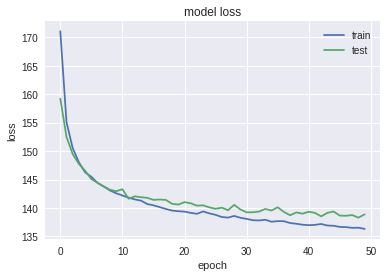

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

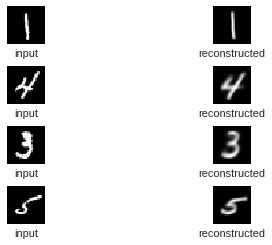

In [27]:
x_val = x_train[8:16]
gen_imgs = vae.predict(x_val)
fig,axes = plt.subplots(4,2)
fig.subplots_adjust(hspace=0.6,wspace=0.6)
n = 0
for i,ax in enumerate(axes.flat):
    
    if i%2==0:
        ax.set_xlabel("input")
        ax.imshow(x_val[n].reshape(28,28), cmap='binary_r')
    else:
        ax.set_xlabel("reconstructed")
        ax.imshow(gen_imgs[n].reshape(28,28), cmap='binary_r')
        n+=1
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()